### Intoduction to image segmentation in opencv in python  - 2022 0114 CJH
---
* if you don't have cv2, it, get it with 
  * `pip install opencv-python` from a console or
  * `!pip install opencv-python` from a jupyter cell () note the exclamation point
 * similarly with any of the other libraries you need (numpy, matplotlib, etc)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import time

### open image in correct color space and display with matplotlib

(720, 1280, 3)

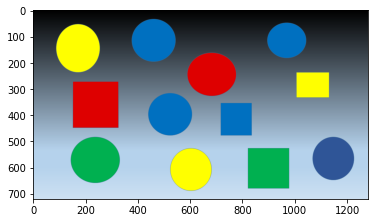

In [2]:
img_rgb = cv2.cvtColor(cv2.imread('training_images/colors.png'), cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)   # Ploting the image using matplotlib
img_rgb.shape

### blur - optional and helps to remove noise

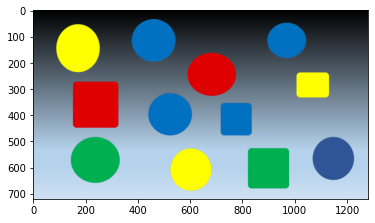

In [3]:
#blurred_image = img_rgb.copy()
radius = 10
ksize = int(2 * round(radius) + 1)
blurred_image = cv2.medianBlur(img_rgb.copy(), ksize)
plt.imshow(blurred_image)

### hsv threshold - pick out colors
* **hues** - rules of thumb for openCV's **0-180** range for hue
  * red is in the 0-10 or 170- 180 range (it is problematic)
  * yellow is in the 20 - 40 range
  * green is in the 70 - 90 range
  * blue is in the 100-120 range
* **sat** is how washed out it is - 0 is gray, 255 is pure color
* **val** is how dark it is - 0 is black, 255 is full brightness

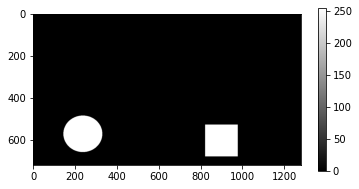

In [4]:
hue = [70, 90]
sat = [128, 255]
val = [100, 255]
hsv_image = cv2.cvtColor(img_rgb.copy(), cv2.COLOR_RGB2HSV)
hsv_thresh_image = cv2.inRange(hsv_image, (hue[0], sat[0], val[0]),  (hue[1], sat[1], val[1]))
plt.imshow(hsv_thresh_image, cmap='gray')
plt.colorbar(shrink=0.75)
plt.show()

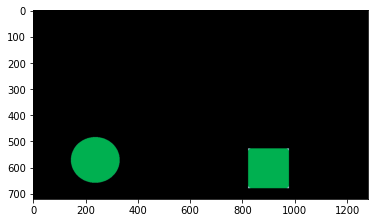

In [5]:
# show the original image through the mask
plt.imshow(blurred_image*(hsv_thresh_image//255)[:,:,np.newaxis])

### find and draw contours 

In [6]:
contours, hierarchy =cv2.findContours(hsv_thresh_image, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
len(contours)

2

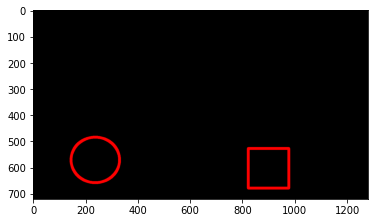

In [7]:
black = np.zeros_like(img_rgb)
color_list =  []
for ix, contour in enumerate(contours):
    color = (255,0,0)
    # color = (([255*int(i) for i in f'{(ix+1) % 8:03b}']))
    cv2.drawContours(black , contours, ix, color, 10)
plt.imshow(black)

In [8]:
cv2.boundingRect(contours[0])

(822, 527, 156, 152)

In [9]:
cv2.contourArea(contours[0])

23405.0

In [10]:
def filter_contours(input_contours, min_area, min_perimeter, min_width, max_width,
                    min_height, max_height, solidity, max_vertex_count, min_vertex_count,
                    min_ratio, max_ratio):
    """Filters out contours that do not meet certain criteria.
    Args:
        input_contours: Contours as a list of numpy.ndarray.
        min_area: The minimum area of a contour that will be kept.
        min_perimeter: The minimum perimeter of a contour that will be kept.
        min_width: Minimum width of a contour.
        max_width: MaxWidth maximum width.
        min_height: Minimum height.
        max_height: Maximimum height.
        solidity: The minimum and maximum solidity of a contour.
        min_vertex_count: Minimum vertex Count of the contours.
        max_vertex_count: Maximum vertex Count.
        min_ratio: Minimum ratio of width to height.
        max_ratio: Maximum ratio of width to height.
    Returns:
        Contours as a list of numpy.ndarray.
    """
    output = []
    for contour in input_contours:
        x,y,w,h = cv2.boundingRect(contour)
        if (w < min_width or w > max_width):
            continue
        if (h < min_height or h > max_height):
            continue
        area = cv2.contourArea(contour)
        if (area < min_area):
            continue
        if (cv2.arcLength(contour, True) < min_perimeter):
            continue
        hull = cv2.convexHull(contour)
        solid = 100 * area / cv2.contourArea(hull)
        if (solid < solidity[0] or solid > solidity[1]):
            continue
        if (len(contour) < min_vertex_count or len(contour) > max_vertex_count):
            continue
        ratio = (float)(w) / h
        if (ratio < min_ratio or ratio > max_ratio):
            continue
        output.append(contour)
    return output

In [11]:
min_area = 500.0
min_perimeter = 40.0
min_width = 20.0
max_width = 1000.0
min_height = 20.0
max_height = 1000
solidity = [24.280575539568343, 100.0]
max_vertices = 1000000
min_vertices = 0
min_ratio = 0.5
max_ratio = 1.5
filtered_contours = filter_contours(contours, min_area, min_perimeter, min_width, max_width,
                    min_height, max_height, solidity, max_vertices, min_vertices,
                    min_ratio, max_ratio)

In [12]:
len(filtered_contours)

2

In [13]:
def overlay_bounding_boxes(image, contours):
    """Draw a box around all of our contours with the main one emphasized"""
    for ix, contour in enumerate(contours):
        color = ([255*int(i) for i in f'{(ix+1) % 7:03b}'])
        rect = cv2.boundingRect(contour)
        thickness = 5
        #print(rect)
        image = cv2.rectangle(image, (int(rect[0]), int(rect[1])), (int(rect[0] + rect[2]), int(rect[1] + rect[3])), color, thickness)
    return image

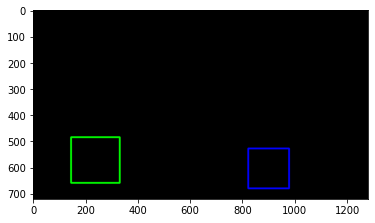

In [14]:
black = np.zeros_like(img_rgb)
contour_image = overlay_bounding_boxes(black, contours)
plt.imshow(contour_image)

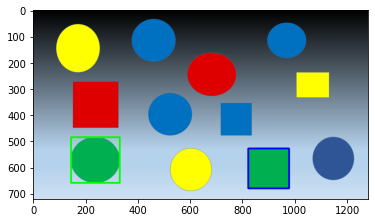

In [15]:
boxed_image = overlay_bounding_boxes(img_rgb.copy(), contours)
plt.imshow(boxed_image)

In [16]:
def overlay_text(image, contours):
    """Draw a box around all of our contours with the main one emphasized"""
    for ix, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        image = cv2.putText(image, str(ix), (int(x+0.4*w), int(y+0.6*h)), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,0), 3);
    return image

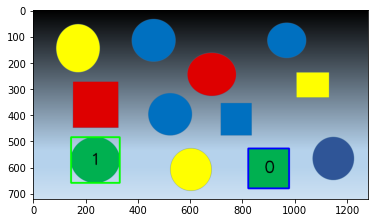

In [17]:
labeled_image = overlay_text(boxed_image.copy(), contours)
plt.imshow(labeled_image)

---
### putting it all together

In [18]:
def process(image, bgr=False, show_blur=False):
    im = image.copy()
    # blur the image
    ksize = int(2 * round(radius) + 1)
    blurred_image = cv2.medianBlur(im, ksize)
    # get the hsv threshold image
    if bgr:
        conversion_type = cv2.COLOR_BGR2HSV
    else:
        conversion_type = cv2.COLOR_RGB2HSV
    hsv_image = cv2.cvtColor(blurred_image.copy(), conversion_type)
    hsv_thresh_image = cv2.inRange(hsv_image, (hue[0], sat[0], val[0]),  (hue[1], sat[1], val[1]))
    # find contours
    contours, hierarchy =cv2.findContours(hsv_thresh_image, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = filter_contours(contours, min_area, min_perimeter, min_width, max_width,
                    min_height, max_height, solidity, max_vertices, min_vertices,
                    min_ratio, max_ratio)
    if show_blur:
        boxed_image = overlay_bounding_boxes(blurred_image, filtered_contours)  # show original
    else:
        boxed_image = overlay_bounding_boxes(im, filtered_contours)  # show blurred
    labeled_image = overlay_text(boxed_image, filtered_contours)
    # plt.imshow(boxed_image)
    return boxed_image, filtered_contours

In [19]:
hue = [0, 10]
sat = [128, 255]
val = [100, 255]

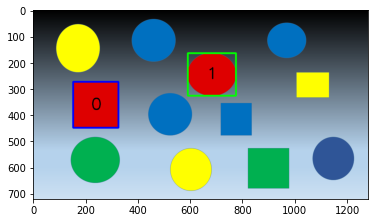

In [20]:
boxed_image, contours = process(img_rgb)
plt.imshow(boxed_image)

### make a nice table of the objects found

In [21]:
img_rgb.shape 

(720, 1280, 3)

In [22]:
rects = []
im_h, im_w, _ = img_rgb.shape 
for contour in contours:
    rect = cv2.boundingRect(contour)
    x, y, w, h = rect
    moments = cv2.moments(contour)  # moments 
    rects.append({'rect_x':x+w/2, 'rect_y':y+h/2, 'centroid_x':(moments["m10"] / moments["m00"]),
                 'centroid_y':moments["m01"] / moments["m00"],
                 'width':w, 'height':h,
                 'vertical':h/im_h, 'horizontal':w/im_w,
                 'image_percent':100 * w*h / (im_h * im_w)})

In [23]:
# display the list of dictionaries in a dataframe
df = pd.DataFrame(rects)
df.round(2)

,rect_x,rect_y,centroid_x,centroid_y,width,height,vertical,horizontal,image_percent
0,239.5,360.5,239.00,360.0,173,175,0.24,0.14,3.29
1,683.0,245.0,682.58,244.6,184,162,0.22,0.14,3.23


### if you know the camera's field of view (fov) and the target's actual size
* you can determine the distance to the object
* you can determine the angle you need to turn through to line up with the object

---
### take a single image from your webcam
* hit any key to close the image - this locks up python until you do

In [25]:
camera_port = 0  # usually 0 is you only have one camera
cam = cv2.VideoCapture(camera_port, cv2.CAP_DSHOW)  # regular USB cams on windows
s, image_raw = cam.read()  # the read function returns a tuple - if the frame was read correctly and the image
if s > 0:
    cv2.imshow(f'Test Picture', image_raw)  # pop open an image window
else:
    print(f'No video on camera: {camera_port}', end = '\n')
# release the camera, wait for the user to hit escape, then close the openCV window
cam.release()
cv2.waitKey(0)
cv2.destroyAllWindows()

# can display here too, but have to fix the BGR (openCV standard) to RGB (everything else)
# plt.imshow(cv2.cvtColor(image_raw, cv2.COLOR_BGR2RGB))

---
### track our own image - set the hue, sat, val and contour filters

In [73]:
radius = 3  # blur 

hue = [160, 180]  #hsv
sat = [100, 255]
val = [100, 255]

# filter contours
min_area = 500.0
min_perimeter = 40.0
min_width = 20.0
max_width = 1000.0
min_height = 20.0
max_height = 1000
solidity = [24.280575539568343, 100.0]
max_vertices = 1000000
min_vertices = 0
min_ratio = 0.25
max_ratio = 4

### run our pipeline on the webcam
* hit any key to close the image - this locks up python until you do

In [27]:
cam = cv2.VideoCapture(0, cv2.CAP_DSHOW)  # open a regular USB cams

# loop over images
count = 0  # keep track of how many images we took 
start_time = time.time()  # get a start time
elapsed_time = 0  # keep track of how much time has elapsed

duration = 10 # seconds to loop
max_count = 100 # take no more than this many images

while count < max_count and elapsed_time < duration:
    count += 1  # increment our counter
    s, image_raw = cam.read()  # read from the camera
    if s > 0:  # test if the camera actually returned a success
        
        resize = False  # change this to true if your computer is slow
        if image_raw.shape[1] > 400 and resize:  # constrain the max width (shape[1])
            scale_percent = 50  # percent of original size
            new_width = int(image_raw.shape[1] * scale_percent / 100)
            new_height = int(image_raw.shape[0] * scale_percent / 100)
            image_raw = cv2.resize(image_raw.copy(), (new_width, new_height), interpolation=cv2.INTER_AREA)  # rewrite the raw image

        # run our vision pipeline on the raw image 
        boxed_image, contours = process(image_raw, bgr=True, show_blur=False)
        
        # show HSV values for a small box in the center
        if True:
            # show the center pixel values
            x_center, y_center = image_raw.shape[1] // 2, image_raw.shape[0] // 2
            width, height = 20, 20
            # extract the center box and convert to HSV
            center_box = cv2.cvtColor(image_raw, cv2.COLOR_BGR2HSV)[y_center-height:y_center+height, x_center-width:x_center+width, :]
            # calculate HSV mean values in the box
            center_box_hue = center_box[:, :, 0].mean(); center_box_sat = center_box[:, :, 1].mean(); center_box_val = center_box[:, :, 2].mean()
            
            textcolor = (255,255,255)
            boxed_image = cv2.rectangle(boxed_image, (x_center-width, y_center-height),(x_center+width, y_center+height), (0,255,255))
            cv2.putText(boxed_image, f'Box HSV values - H:{center_box_hue:.0f} S:{center_box_sat:.0f} V:{center_box_val:.0f}', (10, 20), 1, 1, textcolor, 2, cv2.LINE_AA)  # text: img, text, location, font, scale, color, thickness, line type 
            
        cv2.imshow(f'Image Processing Pipeline', boxed_image)
        cv2.waitKey(10)  # need this or it won't redraw - wait x milliseconds between frames
    else:
        print(f'No video: {count}', end = '\r')
    elapsed_time = time.time() - start_time 

cam.release()
# close video display on key press
cv2.waitKey(0)
cv2.destroyAllWindows()
print(f'Took {count} images')

Took 40 images
